In [1]:
import pandas as pd
import numpy as np
import json
from urllib.request import urlopen
import sklearn

file = open('MitreData.json')

obj_list = []
dict = {}

for line in file:
    # line=line + '\n'
    obj_list.append(eval(line))

new_list = []
for item in obj_list:
    
    dict = item
    new_list.append(dict)

df = pd.DataFrame(new_list)
df.head()

,techniquename,detection,description,mitigations,procedureexamples,id,subtechniqueof,tactics,platforms,version,...,subtechniques,capecid,contributors,impacttype,permissionsrequired,requiresnetwork,systemrequirements,defensebypassed,effectivepermissions,supportsremote
0,Web Services,Once adversaries leverage the web service as i...,Adversaries may register for web services that...,{'M1056': ' Pre-compromise : This technique c...,{'G0025': ' APT17 : APT17 has created profile...,T1583.006,T1583,[Resource Development],[PRE],1.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Virtual Private Server,Once adversaries have provisioned a VPS (ex: f...,Adversaries may rent Virtual Private Servers (...,{'M1056': ' Pre-compromise : This technique c...,{'G0125': ' HAFNIUM : HAFNIUM has operated fr...,T1583.003,T1583,[Resource Development],[PRE],1.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DNS Server,Much of this activity will take place outside ...,Adversaries may set up their own Domain Name S...,{'M1056': ' Pre-compromise : This technique c...,NaN,T1583.002,T1583,[Resource Development],[PRE],1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Acquire Infrastructure,Consider use of services that may aid in track...,"Adversaries may buy, lease, or rent infrastruc...",{'M1056': ' Pre-compromise : This technique c...,NaN,T1583,NaN,[Resource Development],[PRE],1.1,...,"[T1583.001, T1583.002, T1583.003, T1583.004, T...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Server,Once adversaries have provisioned a server (ex...,"Adversaries may buy, lease, or rent physical s...",{'M1056': ' Pre-compromise : This technique c...,{'G0093': ' GALLIUM : GALLIUM has used Taiwan...,T1583.004,T1583,[Resource Development],[PRE],1.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:

fileD=open('DataSources.json')
objD_list = []
for line in fileD:
    objD_list.append(eval(line))
    
df_DS = pd.DataFrame(objD_list)
df_DS.head()

,name,description,id,platform,collectionlayer,version,created,lastmodified,datacomponents,platforms,contributors,collectionlayers
0,Malware Repository,Information obtained (via shared or submitted ...,DS0004,PRE,OSINT,: 1.0,20 October 2021,20 October 2021,"[{'Malware Content': {'description': 'Code, st...",NaN,NaN,NaN
1,Named Pipe,Mechanisms that allow inter-process communicat...,DS0023,NaN,Host,: 1.0,20 October 2021,10 November 2021,[{'Named Pipe Metadata': {'description': 'Cont...,"Linux, Windows, macOS",: Center for Threat-Informed Defense (CTID),NaN
2,Internet Scan,Information obtained (commonly via active netw...,DS0035,PRE,OSINT,: 1.0,20 October 2021,20 October 2021,[{'Response Content': {'description': 'Logged ...,NaN,NaN,NaN
3,Network Share,A storage resource (typically a folder or driv...,DS0033,NaN,Host,: 1.0,20 October 2021,10 November 2021,[{'Network Share Access': {'description': 'Ope...,"Linux, Windows, macOS",: Center for Threat-Informed Defense (CTID),NaN
4,Active Directory,A database and set of services that allows adm...,DS0026,NaN,NaN,: 1.0,20 October 2021,10 November 2021,[{'Active Directory Credential Request': {'des...,"Azure AD, Windows",: Center for Threat-Informed Defense (CTID),"Cloud Control Plane, Host"


In [3]:
tramp_small=pd.read_json('TrampData.json')

tramp=pd.read_json('TrampDataSmall.json')

df_tramp=tramp['sentences']
df_tramp_small=tramp_small['sentences']

df_tramp.append(df_tramp_small,ignore_index=True)

0        {'text': 'From these reports, we know that the...
1        {'text': 'We believe this access was abused, f...
2        {'text': 'What does the resulting watering hol...
3        {'text': 'This targeting of third party organi...
4        {'text': 'Online news outlets and general webs...
                               ...                        
12746    {'text': '"My God" was one of the first songs ...
12747    {'text': 'It initially had seven students.', '...
12748    {'text': 'Vellarikundu is a hillside town and ...
12749    {'text': 'This earned the score a parental adv...
12750    {'text': 'Acanthocardamum is a monotypic genus...
Name: sentences, Length: 12751, dtype: object

In [4]:


dict_tr={'id':[],'text':[]}
index=0
for i in df_tramp:
    
    if not i['mappings']:
        continue
    idv=i['mappings'][0]['attack_id']
    
    dict_tr['id'].append(idv)
    dict_tr['text'].append(i['text'])
    
df_tr=pd.DataFrame(dict_tr)

In [5]:
df_comb=df.join(df_tr.set_index('id'),on='id')

In [6]:

df_comb.drop(['subtechniqueof'],axis=1)
df_comb.drop(['subtechniques'],axis=1)

for x in df_comb:
    
    df_comb[x]=df_comb[x].fillna(method='bfill',axis=0)
    df_comb[x]=df_comb[x].fillna(method='ffill',axis=0)
    df_comb[x]=df_comb[x].interpolate(method='linear',limit_direction='forward',axis=0)

df_comb.isnull().sum()

techniquename           0
detection               0
description             0
mitigations             0
procedureexamples       0
id                      0
subtechniqueof          0
tactics                 0
platforms               0
version                 0
created                 0
lastmodified            0
subtechniques           0
capecid                 0
contributors            0
impacttype              0
permissionsrequired     0
requiresnetwork         0
systemrequirements      0
defensebypassed         0
effectivepermissions    0
supportsremote          0
text                    0
dtype: int64

In [7]:
df_comb['id'].value_counts()
tids = df_comb['id'].unique()
dict_target = {}
dict_tactic= {}
i = 0
for x in tids:
     dict_target[x] = i
     dict_tactic[x]=df_comb.loc[df_comb['id']==x,'tactics'].append(df_comb.loc[df_comb['id']==x,'techniquename'])
     i = i + 1
#print(dict_target)

df_comb['num_target']=df_comb['id'].map(dict_target)

In [10]:
from scipy.stats import sem
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedKFold,StratifiedKFold,StratifiedShuffleSplit,StratifiedGroupKFold,RepeatedStratifiedKFold, GroupShuffleSplit,ShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score,cross_val_predict

X = df_comb.loc[:, df_comb.columns != 'techniquename'].apply(lambda x: ",".join(x.astype(str)), axis=1)
y=df_comb['num_target']


vect = CountVectorizer(ngram_range=(2,2),stop_words='english')

vect.fit_transform(X)
# vect.transform(y)
model = MultinomialNB(alpha =0.2)

clf=make_pipeline(vect,model)

cv = RepeatedKFold(n_splits=4, n_repeats=10, random_state=1)
# 0.75257732 0.73966942 0.76033058 0.76239669
cvr=RepeatedStratifiedKFold(n_splits=4,n_repeats=10,random_state=1)

kfold = StratifiedKFold(n_splits=15, shuffle=True, random_state=1)
# [0.75       0.75773196 0.7622739  0.75452196 0.76744186]

sfold=ShuffleSplit(n_splits=6, test_size=0.4, random_state=1)
# [0.74580645 0.74967742 0.73935484 0.72645161 0.73419355 0.7483871 ]



In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=50)

clf.fit(x_train,y_train)

result=clf.predict(x_test)

accuracy_score(result,y_test)

0.25274725274725274

In [9]:



for train_id,test_id in kfold.split(X,y):
  # X_train,X_test=X[train_id],X[test_id]
  clf.fit(X.iloc[train_id],y.iloc[train_id])
  clf.predict(X.iloc[test_id])
  

/home/ellika/sl7/ML/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(


In [10]:
def predict_id(num):
    #print(dict_target)
    for key, value in dict_target.items():
        if num == value:
            return key

In [22]:
test=pd.read_csv('Testcases.csv')

In [23]:
print(test['data input'])

0     provide a set of functions to execute or a com...
1     Monitor network traffic for unusual ARP traffi...
2     Incidents have been observed where adversaries...
3     disabling individual services of high importan...
4      hide a program's true filetype by changing th...
5     The malware basically provides a remote CMD/Po...
6     Trickbot uses this encrypted module to scan th...
7     The removal of the com.apple.quarantine flag b...
8     unusual login activity from unknown or abnorma...
9     Changes to accessibility utility binaries or b...
10    The malware sends an HTTP GET request to its C...
11    Authentication logs can be used to audit login...
12    leveraging external-facing remote services to ...
13    Linfo creates a backdoor through which remote ...
14    While invoking API functions, adversaries may ...
15    tools identified, including built-in or added-...
16    command line usage and context of archiving to...
17    NTFS Alternate Data Streams (ADSs) may be 

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score,precision_score,recall_score,f1_score
import matplotlib.pyplot as plt

def predict_values():

    dict_result={}
    dict_scores={'precision':'','recall':'','accuracy':'','f1_score':''}
    y_actual=[]
    result=[]

    for index,row in test.iterrows():
        if row['data input'] :
            dict_result[index]={}
            pred=clf.predict([row['data input']])
            y_actual.append(row['actual id'])
            result.append(predict_id(pred))
            dict_result[index]['sentence']=row['data input']
            dict_result[index]['actual_id']=row['actual id']
            dict_result[index]['predict_id']=predict_id(pred)
    y_actual=np.array(y_actual)
    result=np.array(result)
    dict_scores['precision']=precision_score(y_actual,result,average='macro',zero_division=1)
    dict_scores['recall']=recall_score(y_actual,result,average='macro',zero_division=1)
    dict_scores['f1_score']=f1_score(y_actual, result, average='macro',zero_division=1)
    dict_scores['accuracy']=balanced_accuracy_score(y_actual,result)
    fig, ax = plt.subplots()
    plt.plot(recall_score(y_actual,result,average=None,zero_division=1), precision_score(y_actual,result,average=None,zero_division=1), color='purple')

#add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

#display plot
    plt.show()

    return (dict_result,dict_scores)
    


/home/ellika/sl7/ML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


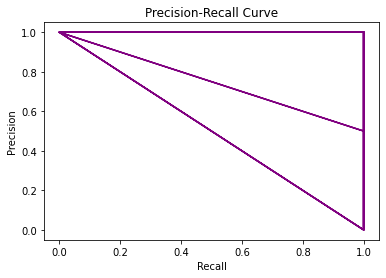

{'precision': 0.75, 'recall': 0.7307692307692307, 'accuracy': 0.65, 'f1_score': 0.48717948717948717}


4526

In [25]:

filer,scores=predict_values()

print(scores)
fp=open('dictdata1.json','w+')
fp.write(json.dumps(filer))

In [19]:
#T1558.004 AS-REP Roasting
desc = ["Monitor network traffic for unusual ARP traffic, gratuitous ARP replies may be suspicious. Consider collecting changes to ARP caches across endpoints for signs of ARP poisoning. For example, if multiple IP addresses map to a single MAC address, this could be an indicator that the ARP cache has been poisoned"] 
# T1134 Access Token Manipulation
desc3=["Monitor the file system for files that have the setuid or setgid bits set. Also look for any process API calls for behavior that may be indicative of [Process Injection]"]
desc2 = ["Suspicious Process Activity- Targeted - Malicious Start Menu Startup Modification Analytic -A2B - EDR "]
# test = vect.transform(desc3)
# pred=cross_val_predict(clf, X, y, cv=cvr)

t1=["Windows processes abused this way in the past; when the processes are started they may not have the standard parent that we would expect"]
pred= clf.predict(t1)
print(pred)


r1=predict_id(pred)
r = dict_tactic[r1]
print (r)
print(r1)

[355]
355    [Defense Evasion, Privilege Escalation]
355              Portable Executable Injection
dtype: object
T1055.002


In [1]:
import sys


print(sys.version)

from flask import Flask, request
from flask_cors import CORS, cross_origin
#from werkzeug import secure_filename
from werkzeug.utils import secure_filename
app = Flask(__name__)
CORS(app)


@app.route('/', methods = ['GET'])
def default():
    return "hi"

@app.route('/upload', methods = ['POST'])
def upload_file():
    file = request.files['file']
    print(file)
    print(type(file))
    file.save(secure_filename(file.filename))
    return "done"

# ef returnTech():
#     dict = predict(file)d

if __name__ == '__main__':
    #app.run(host="0.0.0.0", port=8089)
    app.run(debug = True)

3.8.10 (default, Nov 26 2021, 20:14:08) 
[GCC 9.3.0]


ModuleNotFoundError: No module named 'flask'